---
description: Here we show how to solve the portfolio optimization with a measure of expected shortfall risk using JijZept.
---

# Dynamic Asset Allocation with Expected Shortfall

<!-- # ショートフォールを考慮したポートフォリオ最適化 -->

<!-- ## 導入 -->

## Introduction

<!-- 投資において目標とする資産額あるいは投資リターンに到達しない確率を、ショートフォールリスクと呼びます。ポートフォリオ最適化に期待ショートフォールのリスク指標を導入すると、ダイナミックに市場が動くような極端なモデルでもリターンを考えることが可能になります。目標リターンは[Markowitzのポートフォリオ最適化モデル](https://doi.org/10.2307/2975974)の制約条件として扱い、目標とするショートフォールを満たすように目標リターンを動的に調整する反復アルゴリズムが、[Xu et al., 2023](https://doi.org/10.3390/e25030541)により提案されました。今回はこれを題材に、JijModelingとJijZeptの使い方を学びましょう。 -->

The probability of not reaching a target asset amount or investment return on an investment is called shortfall risk.
Introducing a measure of expected shortfall risk in portfolio optimization makes it possible to consider returns even in extreme models where the market moves dynamically.
[Xu et al. (2023)](https://doi.org/10.3390/e25030541) treated target returns as constraints in the [Markowitz portfolio optimization model](https://doi.org/10.2307/2975974) and proposed an iterative algorithm that dynamically adjusts target returns to meet target shortfalls.
In this article, we use JijModeling and JijZept to implement this algorithm.

<!-- ## 動的資産配分 (Dynamic Asset Allocation) -->

## Dynamic Asset Allocation

<!-- 動的資産配分問題とは、リスクを所定の閾値以下に抑えながら期待リターンを満たすように、$N$個の資産に資金を配分/投資する問題です。この問題の入力には次のようなものが用いられます。これまでのリターンを表した行列$R$をファイナンスデータから取得します。この行列は$N$行$D_\mathrm{total}$列で表されます。ここで$N$は対象とする銘柄数、$D_\mathrm{total}$は対象とする日数です。これを$T$の期間に分け、各期間のデータにインデックスを振り分けます。例えば$R_t$は、$t$番目の期間のリターンを表します。そしてその$R_t$から計算される平均を$\mu_t$とすると、$t$番目の共分散行列は -->

The dynamic asset allocation problem is the problem of allocating/investing funds in $N$ assets to meet expected returns while keeping risk below a given threshold.
A $N \times D_\mathrm{total}$ matrix $R$ representing the returns are obtained from the finance data.
$N$ is the number of stocks to be covered and $D_\mathrm{total}$ is the number of days data are collected. 
We divide $R$ into the period of $T$ days and index the data for each time period.
For example, $R_t$ represents the return data from $t$-th period.
$\mu_t$ is the mean value calculated from $R_t$.
Using these quantities, the covariance matrix of $t$-th period $C_t$ is calculated as 

$$
C_{t, i, j} = \frac{(\mathbf{e}_i^\top R_t - \mu^\top_{t, i} \mathbf{1}) \cdot  (\mathbf{e}_j^\top R_t - \mu^\top_{t, j} \mathbf{1})}{T-1} \tag{1}
$$

<!-- のように計算されます。ここで$\mathbf{e}_i$は、$i$番目の成分は1、それ以外の成分は0となるような列ベクトルです。  
資産配分では、予測不可能な市場の乱高下がある時期には困難なものとなります。そのため、その時期のリスクを回避するための閾値を設けておかなければなりません。リスク閾値は、例えば2008年のリーマンショック時の市場暴落のような不安定な時期から求められた市場指標を用いて設定するなどの例があります。その閾値を上回っているかどうかのリスク測定手法の代表的なものには、以下のようなものがあります。 -->

where $\mathbf{e}_i$ is a column vector of all zeros except with a one at the $j$-th position.
Asset allocation could be a challenging problem during periods of unpredictable market turbulence.
Therefore, we should set a threshold to avoid risk during those periods.
The risk threshold can be set using observed market metrics from a volatile time period, for example, the 2008 market crash.
Major methods of risk measurement include:

<!-- - ボラティリティ: ポートフォリオリターンの標準偏差
- $\alpha$レベルにおけるバリュー・アット・リスク: ポートフォリオが総予算の$y$%以上を失わない確率が、少なくとも$1-\alpha$となるような最小の$y$
- $\alpha$レベルにおける期待ショートフォール: 最悪の$\alpha$%のケースから得られる期待収益 -->

- Volatility: the standard deviation of the portfolio return.
- Value-at-Risk at level $\alpha$:  the smallest number $y$ such that the probability that a portfolio does not lose more than $y$ of total budget is at least $1−α$.
- Expected Shortfall at level $\alpha$: the expected return from the worst $\alpha$% cases.

<!-- 以降では、期待ショートフォールを用いた定式化を考えていきましょう。 -->

In the following sections, we focus on the expected shortfall as our risk measurement and consider a formulation for portfolio optimization problem.

<!-- ## 期待ショートフォールを考慮したポートフォリオ最適化 -->

## Expected Shortfall based Portfolio Optimization

<!-- 期待ショートフォール$\mathrm{ES}_\alpha$は以下のように計算されます。 -->

The expected shortfall al level $\alpha$ is defined as:

$$
\mathrm{ES}_\alpha (w_t, R_t) = \mathrm{mean}(\mathrm{lowest} \ \alpha \% \ \mathrm{from} \ w_t^\top R_t) \tag{2}
$$

<!-- ここで$w_t$は、$t$番目の期間において予算の何割を各資産に投資するかを表す重み付けベクトルです。最悪ケースの平均である期待ショートフォールは最小化したい対象となります。よって、これを考慮した場合のポートフォリオ最適化は、「全資産を投資するという制約下で$\mathrm{ES}_\alpha$を最小化しつつ、期待リターンを満足し、ポートフォリオ分散も小さくする」という問題となります。しかし、この期待ショートフォールは2次形式で表現することができないため、もしこれをQUBOにしようとすると補助変数などを新たに導入する必要が生まれます。
よってこの困難を回避するために、ここでは期待ショートフォールを収束基準として用いることにしましょう。
またその基準計算のために、これまでのリターンがガウス分布に従うと仮定し、与えられたポートフォリオ$P$の期待ショートフォールを以下のように近似して求めることにします。 -->

where the weight vector $w_t$ indicates what fraction of the budget is invested in each asset in the $t$th period.
We minimize the expected shortfall, which is the worst-case average.
Therefore, portfolio optimization considering expected shortfall becomes a problem of minimizing the expected shortfall $\mathrm{ES}_\alpha$ under the constraints that the expected return is satisfied, the variance of the portfolio is small, and all assets are invested.
However, the expected shortfall cannot be expressed by a quadratic formulation natively.
If we reformulate it to QUBO, it is necessary to introduce new auxiliary variables.
Therefore, to avoid this difficulty, we treat the expected shortfall as the convergence criterion.
To do this approach, assuming that the assets’ historical returns follow a Gaussian distribution, we can approximate the expected shortfall of a given portfolio $P$ by

$$
\mathrm{ES}_\alpha (P) 
= \mu + \sigma \frac{\phi (\Phi^{-1} (\alpha))}{1-\alpha} \tag{3}
$$

<!-- $\mu$は期待されるリターン、$\sigma$はポートフォリオのボラティリティ、$\phi(x)$と$\Phi(x)$はそれぞれガウス分布と累積分布関数を表します。  
市場のリスクの大小を、この基準を用いて判定することにします。例えばリスクが小さい場合には、投資額を少し大きくしてその分大きなリターンを得たいと思うはずです。同様に、市場が不安定でリスクが大きい時期には、リターンを小さくする代わりに損をするリスクを下げる方法が取られるでしょう。このように、その時期の期待ショートフォールに合わせて動的にリターンを変動させるために、[Xu et al., 2023](https://doi.org/10.3390/e25030541)では次のようなアルゴリズムを開発しました。 -->

where $\mu$ is the expected return, $\sigma$ is the volatility of the portfolio, and $\phi(x)$ and $\Phi(x)$ are the Gaussian probability distribution and cumulative distribution functions, respectively.  
We use this criterion as the market risk.
For example, if the risk is small, we make a slightly larger investment to get a larger return.
Conversely, during periods of market turbulence and high risk, we take a lower risk of losing money in exchange for a smaller return.
In order to dynamically vary returns in accordance with the expected shortfall for a given period, [Xu et al. (2023)](https://www.mdpi.com/1099-4300/25/3/541) proposed the following algorithm.

<!-- アルゴリズム: 期待ショートフォールをベースとした$t$番目の時期における動的資産配分  
入力: $\mu_t, R_t, \sigma_\mathrm{ref}, \sigma_{\mathrm{ref}, t}, \mathrm{ES}_\mathrm{ref}, \alpha$  
出力: $w_t$  
1: $p_t = \mathrm{mean} (\mu_t)$.   // リターンを初期化  
2: $\mathrm{EST}_t = \frac{\sigma_\mathrm{ref}}{\sigma_{\mathrm{ref}, t}} \mathrm{ES}_\mathrm{ref}$.   // 目標とする期待ショートフォールを初期化  
3: $C_t = \mathrm{cov}(R_t)$    // 共分散行列を計算  
4: while True do:   
5: &emsp; if $p_t > \max (\mu_t)$:   
6: &emsp; &emsp; return 0.   // 制約が満たされていない  
7: &emsp; $w_t$ = Markowitz($\mu_t, C_t, p_t$).   // Markowitzの定式化をアニーリングで解く  
8: &emsp; $\mathrm{ES}_t = \mathrm{ES}_\alpha (w_t, R_t)$.   // 定義式(2)から期待ショートフォールを計算  
9: &emsp; if $\frac{\mathrm{ES}_t}{\mathrm{EST}_t} > 1 + \epsilon$:  
10:&emsp; &emsp; $p_t = p_t (1-\delta)$.   // もし期待ショートフォールが大きいなら、リターンを小さくして損するリスクを下げる  
11:&emsp; else if: $\frac{\mathrm{ES}_t}{\mathrm{EST}_t} < 1-\epsilon$  
12:&emsp; &emsp; $p_t = p_t (1+\delta)$.   // もし期待ショートフォールが小さいなら、リターンを大きくする余裕がある  
13:&emsp; else:   
14:&emsp; &emsp; return $w_t$   -->

Algorithm: Expected Shortfall based Dynamic Asset Allocation during period $t$  
Input: $\mu_t, R_t, \sigma_\mathrm{ref}, \sigma_{\mathrm{ref}, t}, \mathrm{ES}_\mathrm{ref}, \alpha$  
Output: $w_t$  
1: $p_t = \mathrm{mean} (\mu_t)$.   // Initialize the target return  
2: $\mathrm{EST}_t = \frac{\sigma_\mathrm{ref}}{\sigma_{\mathrm{ref}, t}} \mathrm{ES}_\mathrm{ref}$.   // Initialize the target expected shortfall  
3: $C_t = \mathrm{cov}(R_t)$    // Compute the co-variance matrix from the returns  
4: while True do:  
5: &emsp; if $p_t > \max (\mu_t)$:   
6: &emsp; &emsp; return 0.   // Return constraint cannot be satisfied  
7: &emsp; $w_t$ = Markowitz($\mu_t, C_t, p_t$).   // Solve Markowitz formulation with annealing  
8: &emsp; $\mathrm{ES}_t = \mathrm{ES}_\alpha (w_t, R_t)$.   // Compute the expected shortfall using eq.(2)  
9: &emsp; if $\frac{\mathrm{ES}_t}{\mathrm{EST}_t} > 1 + \epsilon$:  
10:&emsp; &emsp; $p_t = p_t (1-\delta)$.   // Decrease target return for lower risks  
11:&emsp; else if: $\frac{\mathrm{ES}_t}{\mathrm{EST}_t} < 1-\epsilon$  
12:&emsp; &emsp; $p_t = p_t (1+\delta)$.   // Increase target return as there is room for more risks  
13:&emsp; else:   
14:&emsp; &emsp; return $w_t$

<!-- ここで$\sigma_\mathrm{ref}$は2008年の市場暴落時のボラティリティ、$\sigma_{\mathrm{ref}, t}$は$t$番目の時期におけるボラティリティです。そして$\mathrm{ES}_\mathrm{ref}$は同じく2008年の市場暴落時の期待ショートフォールを表し、$\mathrm{EST}_t$は$t$番目の時期における目標とする期待ショートフォールです。$\alpha$はリスクパラメータで、$\mathrm{ES}_t$は$t$番目の時期において[Markowitz定式化](https://doi.org/10.2307/2975974)の最適化結果から計算される期待ショートフォール、$\epsilon$はエラー許容パラメータ、$\delta$は調整されるモメンタムパラメータを表します。途中で解いている[Markowitzの定式化](https://doi.org/10.2307/2975974)とは、以下のようなものです。 -->

where $\sigma_\mathrm{ref}$ is the volatility of a reference asset's returns during the market crash in 2008.
$\sigma_{\mathrm{ref}, t}$ is the volatility of the reference asset's returns during the $t$-th period.
$\mathrm{ES}_\mathrm{ref}$ is the reference asset's expected shortfall during the market crash.
$\mathrm{EST}_t$ is the target expected shortfall at the $t$-th period.
$\alpha$ is the risk level parameter.
$\mathrm{ES}_t$ is the expected shortfall for the computed portfolio during [the optimization process](https://doi.org/10.2307/2975974) at $t$-th period.
$\epsilon$ is the error tolerance parameter, and $\delta$ is the momentum parameter that is adjusted dynamically.
[The Markowitz optimization problem](https://doi.org/10.2307/2975974) can be expressed by the quadratic optimization problem as:

$$
\begin{align}
\min_w & \quad w_t^\top C_t w_t \notag \\
\mathrm{s.t.} & \quad \mu_t^\top w_t \geq 
p_t \\
& \quad \sum_i w_{t, i} = 1, \quad w_{t, i} \geq 0 \quad (\forall i)
\end{align} \tag{4}
$$

<!-- ここでは簡単のため、$w_{t, i}$は$\{0, 1\}$のバイナリ変数であるとします。
制約条件$\sum_i w_{t, i} = 1$から、自分の持っている資産をある一つの銘柄に集中させ、リターンは常に$p_t$より大きくなるようにしています。 -->

For simplicity, we set $w_{t, i}$ are binary variables in $\{0, 1\}$.
From the constraint $\sum_i w_{t, i} = 1$, we concentrate our assets in one stock, and aim the return is always greater than $p_t$.

<!-- ## 実装しましょう -->

## Let's coding!

<!-- ここからは実際にJijModelingとJijZeptを用いて、この問題を解くスクリプトを実装しましょう。 -->

Here, we implement a script that solves this problem using JijModeling and JijZept.

<!-- ### 変数の定義 -->

### Defining variables

<!-- 以下のようにして、(4)式の最適化問題を解くのに用いる変数を定義します。 -->

We define the variables for eq.(4).

In [12]:
import jijmodeling as jm

# define variables
N = jm.Placeholder('N')
p = jm.Placeholder('p')
mu = jm.Placeholder('mu', ndim=1)
C = jm.Placeholder('C', ndim=2)
w = jm.BinaryVar('w', shape=(N, ))
i = jm.Element('i', belong_to=N)
j = jm.Element('j', belong_to=N)

<!-- `N`は購入を検討している銘柄数、`p`はリターンの下限値$p_t$、`mu`は各銘柄のリターン$\mu_t$、`C`は共分散行列$C_t$です。
そして`w`は最適化に用いるバイナリ変数、`i`, `j`はそれぞれ添字に用いる変数です。 -->

`N` is the total number of stocks, `p` is the lower liimit of return $p_t$, `mu` is the return $\mu_t$ for each stock, and `C` is the covariance matrix $C_t$.
`w` is the binary variable for optimization, and `i` and `j` are the indices, respectively.

<!-- ### Markowitz定式化の実装 -->

### Implementing Markowitz formulation

<!-- (3)式で表現される、Markowitzのポートフォリオ最適化の数理モデルを実装しましょう。 -->

Next, we implement [Markowitz mathematical model](https://doi.org/10.2307/2975974) eq.(3).

In [13]:
# set a problem
problem = jm.Problem('shortfall')
# constraint 1: ensure the target return
problem += jm.Constraint('return', jm.sum(i, mu[i]*w[i])>=p)
# constraint 2: buy a stock
problem += jm.Constraint('onehot', jm.sum(i, w[i])==1)
# objective function: minimize variance
problem += jm.sum([i, j], C[i, j]*w[i]*w[j])

<!-- `Problem`で問題を作成し、その次に`Constraint`で2つの制約を実装します。
目的関数の$\sum_i \sum_j C_{i, j} w_i w_j$では、一つの`sum([i, j], ...)`のようにすることで2つの添字での総和を一度に計算することができます。  
Jupyter Notebookであれば、実装された数理モデルを確認することができます。 -->

We generate a problem with `Problem` and then implement two constraints with `Constraint`.
We can implement the sum in two subscripts at once by using `sum([i, j], ...)`.  
With Jupyter Notebook, we can check the mathematical model implemented.  

In [14]:
problem

<!-- ### JijZeptによる求解 -->

### Solving with JijZept

<!-- JijZeptのシミュレーテッド・アニーリング機能を用いて、先ほど実装したMarkowitzのポートフォリオ最適化問題を解きます。 -->

We solve [Markowitz portfolio optimization](https://doi.org/10.2307/2975974) using simulated annealing approach with JijZept.

In [15]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='../config.toml')
# set multipliers
multipliers = {'return': 1.0, 'onehot': 1.0}

<!-- 2つの制約が存在するため、それぞれに対する未定乗数を辞書型で指定します。  
続いて、[Xu et al, 2023](https://doi.org/10.3390/e25030541)で提案されたアルゴリズムを実行するための、サブルーチンを実装していきましょう。 -->

In this problem, we have two constraints. 
Therefore, we specify each multiplier in dictionary type.  
Next, we implement subroutines to execute the algorithm proposed by [Xu et al. (2023)](https://doi.org/10.3390/e25030541).

In [16]:
import numpy as np
from scipy.stats import norm

# a function to compute reference vlatility and expected shortfall
def compute_reference(ref_asset, ref_start_date, ref_end_date, alpha):
    ref_data = web.DataReader(ref_asset, ref_start_date, ref_end_date)['Close']
    ref_volatility = ref_data.std()
    ref_mean = ref_data.mean()
    ref_expected_shortfall = ref_mean + ref_volatility * norm.pdf(norm.ppf(alpha)) / (1-alpha)
    return ref_volatility, ref_expected_shortfall

# a function to extract a solution from results
def extract_solution(results, N):
    # get feasible solutions
    feasibles = results.feasible()
    if feasibles.evaluation.objective == []:
        print('No feasibles solution')
    else:
        # get values of objective function
        objs = feasibles.evaluation.objective
        # get the index of minimum objective value
        min_obj_index = np.argmin(objs)
        # get solution
        w = feasibles.record.solution['w'][min_obj_index]
        # convert solution to binary vector
        list_index = w[0][0]
        list_binary = np.zeros(N, dtype=int)
        list_binary[list_index] = 1
        return list_binary

# solve Markowitz optimization problem
def solve_markowitz(instance_data):
    # compute SA with JijZept
    results = sampler.sample_model(problem, instance_data, multipliers, search=True, num_reads=100)
    w_t = extract_solution(results, instance_data['N'])
    return w_t

# compute expected shortfall from result of Markowitz optimization
def compute_shortfall(alpha, w, ret, vol):
    es = np.dot(w, ret) + np.dot(w, vol) * norm.pdf(norm.ppf(alpha)) / (1-alpha)
    return es

<!-- `compute_reference`は参照データのボラティリティ$\sigma_\mathrm{ref}$と期待ショートフォール$\mathrm{ES}_\mathrm{ref}$を計算する関数、`solve_markowitz`は(3)式の最適化を解く関数です。
`extract_solution`は`solve_markowitz`の結果から目的関数が最小かつ実行可能解であるものを抽出し、それをバイナリのベクトルに変換する関数です。
最後に、`compute_shortfall`は`solve_markowitz`から得られたポートフォリオを用いて、期待ショートフォールを計算します。
これらのサブルーチンを用いて、Xu et al., 2023で提案されたアルゴリズムを実装すると以下のようになります。 -->

`compute_reference` is a function that computes the volatility $\sigma_\mathrm{ref}$ and expected shortfall $\mathrm{ES}_\mathrm{ref}$ of the reference data, 
`solve_markowitz` is for solving the otimization problem eq.(3).
`extract_solution` is a function that extracts the feasible and smallest objective solution from the result of `solve_markowitz`, and converts that solution to a binary vector. 
Lastly, `compute_shortfall` computes the expected shortfall using the portfolio obtained from `solve_markowitz`.
Utilizing these subroutines, we implement the algorithm from [Xu et al. (2023)](https://www.mdpi.com/1099-4300/25/3/541).

In [30]:
import datetime
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
yf.pdr_override()

# set input parameters, alpha, delta and eps
alpha = 0.99
delta = 0.1
eps = 0.25
# set start and end date for reference data
ref_start_date = datetime.date(year=2008, month=1, day=1)
ref_end_date = datetime.date(year=2009, month=1, day=1)
# compute volatility and expected shortfall from reference data
ref_volatility, ref_expected_shortfall = compute_reference('SPY', ref_start_date, ref_end_date, alpha)
# set the name of assets
list_assets = ['SPY', 'EEM', 'QQQ', 'SLV', 'SQQQ', 'XLF', 
                'AUDUSD=X', 'EURUSD=X', 'GBPUSD=X', 'CNYUSD=X', 'INRUSD=X', 'JPYUSD=X']
ref_asset_t = list_assets[0]
# set start date for data and date interval
start_date_t = datetime.date(year=2022, month=1, day=1)
dt = 14
# set the number of iteration
iteration = 6
# initialize lists for final results
list_results = []
list_shortfall = []
list_return = []
list_target = []
# main loop
for _ in range(iteration):
    # set end date
    end_date_t = start_date_t + datetime.timedelta(days=dt)
    # get reference stock data
    ref_data_for_volatility_t = web.DataReader(ref_asset_t, start_date_t, end_date_t)['Close']
    # compute volatility
    ref_volatility_t = ref_data_for_volatility_t.std()
    # compute target expected shortfall
    target_expected_shortfall_t = ref_volatility / ref_volatility_t * ref_expected_shortfall
    # initialize dataframe
    data_assets = pd.DataFrame()
    for asset in list_assets:
        # get stock data and concat 
        data = web.DataReader(asset, start_date_t, end_date_t).rename(columns={'Close': asset})
        data_assets = pd.concat([data_assets, data[asset]], axis=1)
    # if nan exists, drop
    data_assets_dropna = data_assets.dropna(how='any')
    # compute mean
    mean_t = data_assets_dropna.mean(axis=0).values
    # compute covariant matrix
    cov_t = data_assets_dropna.cov().values
    # compute volatility
    volatility_t = data_assets.std().values
    # get the number of assets
    N = len(list_assets)
    # normalize mean, covariant matrix, and pt
    mean_t_normalize = mean_t / mean_t.max()
    cov_t_normalize = cov_t / cov_t.max()
    p_t_normalize = mean_t_normalize.mean()
    instance_data = {'N': N, 'p': p_t_normalize, 'mu': mean_t_normalize, 'C': cov_t_normalize}
    while True:
        w_t = solve_markowitz(instance_data)
        if p_t_normalize > max(mean_t_normalize):
            print('Caution!!! Return constraint cannot be satisfied!!!')
            break
        expected_shortfall_from_markowitz = compute_shortfall(alpha, w_t, mean_t, volatility_t)
        if abs(expected_shortfall_from_markowitz) / abs(target_expected_shortfall_t) > 1 + eps:
            instance_data['p'] *= 1 - delta
        # elif abs(expected_shortfall_from_markowitz) / abs(target_expected_shortfall_t) < 1 - eps:
        #     instance_data['p'] *= 1 + delta
        else:
            break
    start_date_t = end_date_t
    list_results.append(w_t)
    list_shortfall.append(expected_shortfall_from_markowitz)
    list_target.append(target_expected_shortfall_t)
    list_return.append(mean_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_2291/1762517325.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:


<!-- ### 結果の可視化 -->

### Visualizing result

<!-- 先程得た結果を可視化してみましょう。 -->

We plot the obtained result.

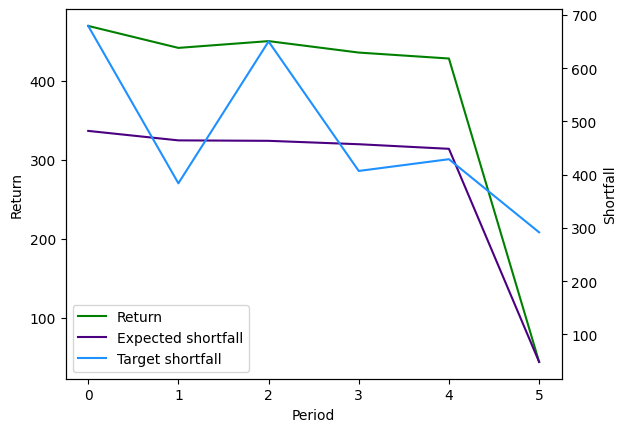

In [41]:
import matplotlib.pyplot as plt

list_final_ret = [np.dot(x, y) for x, y in zip(list_results, list_return)]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Period')
ax1.set_ylabel('Return')
ln1 = ax1.plot(list_final_ret, color='green', label='Return')
ax2 = ax1.twinx()
ax2.set_ylabel('Shortfall')
ln2 = ax2.plot(list_shortfall, color='indigo', label='Expected shortfall')
ln3 = ax2.plot(list_target, color='dodgerblue', label='Target shortfall')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left')

<!-- 一番最後のperiodでは、目標とするショーフォール(target shortfall)が減少しています。
それに合わせて期待ショートフォールが下がるようにポートフォリオを選んだ結果、得られるリターンが小さくなっています。 -->

In the last period 5, the target shortfall is decreasing.
The portfolio is chosen so that the expected shortfall decrease accordingly, resulting in a smaller return.

<!-- ## 参考文献 -->

## References

* [Xu et al., 2023, "Dynamical Asset Allocation with Expected Shortfall via Quantum Annealing"](https://www.mdpi.com/1099-4300/25/3/541)  
* [Markowitz, 1952, "Portfolio Selection"](https://doi.org/10.2307/2975974)  